In [108]:
class OptionPricing:
    def __init__(self, stock_name, strike_price, ttm, option_type = 'Call', visualization = True,MC_simulations): 
        self.stock_name = stock_name
        self.option_type = option_type
        self.visual = visualization
        self.strike_price = strike_price
        self.ttm = ttm
        self.simulations = MC_simulations
        
    
    def get_stock_info(self, start = 0, end = 0):

        import pandas as pd
        import numpy as np
        import datetime
        import pandas_datareader.data as web
        import fix_yahoo_finance as yf
        end = datetime.date.today()
        start = end - datetime.timedelta(days = 252*10)
        try:
            data = web.get_data_yahoo(self.stock_name, start,end)
            data['Return'] = data['Close'].pct_change()
            data = data.dropna()
            self.std = data['Return'].describe().loc['std']
            self.std = self.std * np.sqrt(252) #annualize
            self.price = data['Close'].iloc[len(data)-1]

            return self.price, self.std

        except:
            print('Cannot find stock data')
    
    
    
    def get_rf(self, date = 0, tenor = '10 yr'):
        import pandas as pd
        import requests
        from bs4 import BeautifulSoup
        import datetime
        
        url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
        response = requests.get(url)

        if response.status_code == 200:
            data_page = BeautifulSoup(response.content,'lxml')
            yield_table = data_page.find('table', class_ = 't-chart')
            trs = yield_table.find_all('tr')
            col = [trs[0].find_all('th', scope = 'col')[i].get_text() 
                    for i in range(1,len(trs[0].find_all('th', scope = 'col')))]
            index = [trs[i].find_all('td', scope = 'row')[0].get_text() for i in range(1,len(trs))]

            rates = [[float(trs[i].find_all('td')[j].get_text()) for j in range(1,len(col)+1)] for i in range(1,len(trs))]
            data = pd.DataFrame(rates, columns = col, index = index)
            data = data/100 #pct_value

            date = data.index.values[len(data)-1] #latest data

            self.rf_rate = data.loc[date][tenor]
        else:
            print('Failure')

        return self.rf_rate #risk free rate

    
    def BS_model(self):
        import scipy.stats
        import numpy as np
        from math import sqrt, exp
        import pandas as pd

        stock_price, var = self.get_stock_info() # from get_stock_info
        strike_price = self.strike_price
        r_f = self.get_rf()
        ttm =self.ttm
        
        norm_dist = scipy.stats.norm(0, 1)
        d1 = 1/(var * sqrt(ttm)) * (np.log(stock_price/strike_price) +(r_f + (var**2/2))*ttm)
        d2 = d1 - var*sqrt(ttm)

        call_value = norm_dist.cdf(d1) * stock_price - norm_dist.cdf(d2) * strike_price * exp(-r_f * ttm)
        put_value = strike_price * exp(-r_f * ttm) - stock_price + call_value

        delta_call = norm_dist.cdf(d1)
        delta_put = norm_dist.cdf(d1) - 1
        gamma = norm_dist.pdf(d1)/(stock_price * var * sqrt(ttm))
        vega = stock_price * norm_dist.pdf(d1) * sqrt(ttm)
        theta_call = -(stock_price * norm_dist.pdf(d1) * var)/(2*sqrt(ttm))- (r_f * strike_price * 
                                                                              norm_dist.cdf(d2) * exp(-r_f*ttm))
        theta_put = -(stock_price * norm_dist.pdf(d1) * var)/(2*sqrt(ttm))+ (r_f * strike_price * 
                                                                              norm_dist.cdf(-d2) * exp(-r_f*ttm))
        rho_call = strike_price * ttm * norm_dist.cdf(d2) * exp(-r_f * ttm)
        rho_put = -strike_price * ttm * norm_dist.cdf(-d2) * exp(-r_f * ttm)

        price = [call_value, put_value]
        delta = [delta_call, delta_put]
        gamma = [gamma]*2
        vega = [vega]*2
        theta = [theta_call, theta_put]
        rho = [rho_call, rho_put]

        output = [price, delta, gamma, vega, theta, rho]
        col = ['Call', 'Put']
        index = ['Price', 'Delta', 'Gamma', 'Vega', 'Theta', 'Rho']

        self.BS_df = pd.DataFrame(output, columns = col, index = index)
        
        if self.visual == True:
            self.BS_sensitivity_plot()
            
        return self.BS_df 

        
    
    def BS_sensitivity_plot(self):
        
        stock_price, var = self.get_stock_info()
        strike_price = self.strike_price
        r_f = self.get_rf()
        ttm =self.ttm
        option_type = self.option_type
        
        def BS_model(stock_price, var, strike_price, r_f, ttm):
            import scipy.stats
            import numpy as np
            from math import sqrt, exp
            import pandas as pd
            norm_dist = scipy.stats.norm(0, 1)
            
            d1 = 1/(var * sqrt(ttm)) * (np.log(stock_price/strike_price) +(r_f + (var**2/2))*ttm)
            d2 = d1 - var*sqrt(ttm)

            call_value = norm_dist.cdf(d1) * stock_price - norm_dist.cdf(d2) * strike_price * exp(-r_f * ttm)
            put_value = strike_price * exp(-r_f * ttm) - stock_price + call_value

            delta_call = norm_dist.cdf(d1)
            delta_put = norm_dist.cdf(d1) - 1
            gamma = norm_dist.pdf(d1)/(stock_price * var * sqrt(ttm))
            vega = stock_price * norm_dist.pdf(d1) * sqrt(ttm)
            theta_call = -(stock_price * norm_dist.pdf(d1) * var)/(2*sqrt(ttm))- (r_f * strike_price * 
                                                                                  norm_dist.cdf(d2) * exp(-r_f*ttm))
            theta_put = -(stock_price * norm_dist.pdf(d1) * var)/(2*sqrt(ttm))+ (r_f * strike_price * 
                                                                                  norm_dist.cdf(-d2) * exp(-r_f*ttm))
            rho_call = strike_price * ttm * norm_dist.cdf(d2) * exp(-r_f * ttm)
            rho_put = -strike_price * ttm * norm_dist.cdf(-d2) * exp(-r_f * ttm)

            price = [call_value, put_value]
            delta = [delta_call, delta_put]
            gamma = [gamma]*2
            vega = [vega]*2
            theta = [theta_call, theta_put]
            rho = [rho_call, rho_put]

            output = [price, delta, gamma, vega, theta, rho]
            col = ['Call', 'Put']
            index = ['Price', 'Delta', 'Gamma', 'Vega', 'Theta', 'Rho']

            BS_df = pd.DataFrame(output, columns = col, index = index)

            return BS_df
        
        import matplotlib.pyplot as plt
        import numpy as np

        %matplotlib inline

        sen_stock = [BS_model(i, var, strike_price, r_f, ttm).loc['Price'][option_type] for i in np.arange(stock_price *(1-2*var),stock_price *(1+2*var))]
        sen_strike = [BS_model(stock_price, var, i, r_f, ttm).loc['Price'][option_type] for i in np.arange(strike_price *(1-2*var),strike_price *(1+2*var))]
        sen_var = [BS_model(stock_price, i, strike_price, r_f, ttm).loc['Price'][option_type] for i in np.arange(1,100)/100]
        sen_r_f = [BS_model(stock_price, var, strike_price, i, ttm).loc['Price'][option_type] for i in np.arange(1,10)/100]
        sen_time = [BS_model(stock_price, var, strike_price, r_f, i).loc['Price'][option_type] for i in np.arange(1,100)/10]


        stock = np.arange(stock_price *(1-2*var),stock_price *(1+2*var))
        strike = np.arange(strike_price *(1-2*var),strike_price *(1+2*var))
        volatility = np.arange(1,100)/100
        rf = np.arange(1,10)/100
        time = np.arange(1,100)/10

        plt.subplot(321)
        plt.title('Sensitivity to Stock Price')
        plt.ylabel('Option Price')
        plt.xlabel('Stock Price')
        plt.plot(stock,sen_stock )

        plt.subplot(322)
        plt.title('Sensitivity to Strike Price')
        plt.ylabel('Option Price')
        plt.xlabel('Strike Price')
        plt.plot(strike,sen_strike)

        plt.subplot(323)
        plt.title('Sensitivity to Volatility')
        plt.ylabel('Option Price')
        plt.xlabel('Volatility')
        plt.plot(volatility,sen_var)

        plt.subplot(324)
        plt.title('Sensitivity to Int rate')
        plt.ylabel('Option Price')
        plt.xlabel('Risk-Free Rate')
        plt.plot(rf,sen_r_f)

        plt.subplot(325)
        plt.title('Sensitivity to Time')
        plt.ylabel('Option Price')
        plt.xlabel('Time to Maturity')
        plt.plot(time,sen_time)

        plt.subplots_adjust(top=0.99, bottom=0.01, left=0.001, right=0.999, hspace=0.8,
                            wspace=0.2)
        plt.show()



        
        
    def mc_euro_options(self, option_type,S,K,T,r,v,simulations):
        
        option_type = self.option_type
        S, v = self.get_stock_info()
        K = self.strike_price
        r = self.get_rf()
        T = self.ttm
        simulations = self.simulations
        
        from random import gauss
        import math
        from math import exp, sqrt
        
        payoff_sum = 0
        
        for j in range(simulations):
            st = S * exp((r-0.5 * v**2)*T + v*sqrt(T)*gauss(0,1.0))
            if option_type = 'call':
                payoff = max(0,st-K)
            elif option_type = 'put':
                payoff = max(0,K-st)
            payoff_sum += payoff
            
        price_T = (payoff_sum/float(simulations))*exp(-t*T)
        return price_T
        
        
    
    def simulations_converge(self, option_type,S,K,T,r,v,simulations):
        
        option_type = self.option_type
        S,v = self.get_stock_info()
        K = self.strike_price
        r = self.get_rf()
        T = self.ttm
        
        import matplotlib.pyplot as plt
        
        simulation_path = []
        for simulation in range(simulations)[1:]:
            price_T_simulation = mc_euro_options(option_type,S,K,T,r,v,simulation)
            simulation_path.append(price_T_simulation)
            
        plt.plot(simulation_path)
        
        plt.xlabel('simulation times')
        plt.ylabel('option price')
        
        plt.show()
    
    def stock_time(self, S,K,r,v,T):
        S,v=self.get_stock_info()
        K = self.strike_price
        r = self.get_rf()
        T = self.ttm
        
        from random import gauss
        import math
        from math import exp, sqrt
        import matplotlib.pyplot as plt
        
        steps = 252
        time_delta = T/steps
        
        path = 10
        for j in range(path):
            price_path = [S]
            St = S
            for t in range(steps):
                St = St * exp((r - 0.5 *v**2 )*time_delta + v * sqrt(time_delta)*gauss(0,1.0))
                price_path.append(St)
                
            plt.plot(price_path)
            
        plt.xlabel('steps',fontsize=15)
        plt.ylabel('stock price',fontsize = 15)
        
        plt.show()
            
            
            
         
   
    
    def BinomialTreeCRR(self, n=1000):
        
        from math import sqrt, exp
        import numpy as np
        
        stock_price, var = self.get_stock_info()
        r = self.get_rf()

        u = exp(var * sqrt(self.ttm/n))
        d = 1/u

        # p: Risk-neutral 
        p = exp(-r*self.ttm/n) * ((exp(r*self.ttm/n) - d) / (u - d))
        p1 = exp(-r*self.ttm/n) * (1 - p)

        # initial values at time T
        ValueFlow = [max(self.strike_price - stock_price * (u ** (2*i-n)), 0) for i in range(n)]
        callValueFlow = [max((stock_price * u ** (2*i-n) - self.strike_price), 0) for i in range(n)]
        
        stockValue = np.zeros((n+1,n+1))
        stockValue[0,0] = stock_price
        for i in range(1,n+1):
            stockValue[i,0] = stockValue[i-1,0] * u
            for j in range(1,i+1):
                stockValue[i,j] = stockValue[i-1,j-1] * d

        optionValue = np.zeros((n+1,n+1))
        for i in range(n+1):
            if self.option_type == 'Call': # Call Option
                optionValue[n,i] = max(stockValue[n,i]-self.strike_price, 0)
            elif self.option_type == 'Put': # Put Option
                optionValue[n,i] == max(self.strike_price-stockValue[n,i], 0)

        # backtracking
        for i in range(n-1,-1,-1):
            for j in range(i+1):
                if self.option_type == 'Call':
                    optionValue[i,j] = max(stockValue[i,j]-self.strike_price, 0, p*optionValue[i+1,j]+p1*optionValue[i+1,j+1])
                elif self.option_type == 'Put':
                    optionValue[i,j] = max(self.strike_price-stockValue[i,j], 0, p*optionValue[i+1,j]+p1*optionValue[i+1,j+1])

        def CRR_plot():
            import matplotlib.pyplot as plt 

            y = [-optionValue[0][0]] * self.strike_price
            y += [x - optionValue[0][0] for x in range(self.strike_price)] 
            
            if self.option_type == 'Call':
    #             plt.figure(figsize=(10,5))
                plt.plot(range(2*self.strike_price), y)
                plt.axis([0, 2*self.strike_price, min(y) - 10, max(y) + 10])
                plt.xlabel('Asset price')
                plt.ylabel('Profits')
                plt.axvline(x=self.strike_price, linestyle='--', color='black')
                plt.axhline(y=0, linestyle=':', color='black')
                plt.title('Call Option')
                plt.text(100, 0, 'Strike Price')

            elif self.option_type == 'Put':
                z = [-x + self.strike_price - optionValue[0][0] for x in range(self.strike_price)] 
                z += [-optionValue[0][0]] * (self.strike_price)

    #             plt.figure(figsize=(10,5))
                plt.plot(range(2*self.strike_price), z, color='red')
                plt.axis([0, 2*self.strike_price, min(y) - 10, max(y) + 10])
                plt.xlabel('Asset price')
                plt.ylabel('Profits')
                plt.axvline(x=self.strike_price, linestyle='--', color='black')
                plt.axhline(y=0, linestyle=':', color='black')
                plt.title('Put Option')
                plt.text(100, 0, 'Strike Price')
            
        if self.visual == True:
            CRR_plot()
            
        return optionValue[0,0]
    
    
            
        

25.24934795132345

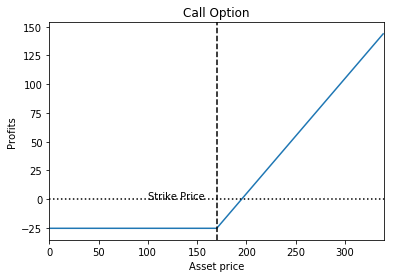

In [109]:
O = OptionPricing('AAPL', 170, 1)
# O.BS_sensitivity_plot()
# O.BS_model()
O.BinomialTreeCRR()